# Mycobacteria

Does anything predict the presence of Mycobacteria? We expect this will be hard because they are not well characterised in culturing and difficult to extract DNA from.

## Set up and reading the data

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib


In [2]:
# we are goingt to use SHAP to look for some positive correlations.
import shap

In [3]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa)
print(f"The data frame has shape {df.shape}")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


The data frame has shape (127, 1512)


## Make a boxplot

This is a boxplot of all the read abundances against the Mycobacteriaceae read abundance

In [4]:
myco = metadata[['NTM',
                 'CS_Mycobacteroides abscessus', 'CS_Mycobacterium intracellulare', 'CS_NTM_(Smear negative)', 'CS_MAC_(Smear negative)',
                 'O_Mycobacterium abscessus', 'O_Mycobacterium intracellular', 'P12M_4_Rapid NTM', 'P12M_5_Slow NTM',
                 'N12M_MAC'
                ]].dropna(axis=0).copy()
merged = df[['Mycobacteriaceae']].join(myco, how='inner')
merged

,Mycobacteriaceae,NTM,CS_Mycobacteroides abscessus,CS_Mycobacterium intracellulare,CS_NTM_(Smear negative),CS_MAC_(Smear negative),O_Mycobacterium abscessus,O_Mycobacterium intracellular,P12M_4_Rapid NTM,P12M_5_Slow NTM,N12M_MAC
1162967_20180116_S,572.471014,1.0,0,0,0,0,0,0,0.0,0.0,1.0
1651490_20171215_S,513.733532,0.0,0,0,0,0,0,0,0.0,0.0,0.0
1470026_20180502_S,845.430406,0.0,0,0,0,0,0,0,0.0,0.0,0.0
1593967_20180424_S,753.968254,0.0,0,0,0,0,0,0,0.0,0.0,0.0
1593973_20180427_S,785.942503,0.0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
788707_20181129_S,401.636756,0.0,0,0,0,0,0,0,0.0,0.0,0.0
802187_20180321_S,736.829636,0.0,0,0,0,0,0,0,0.0,0.0,0.0
877469_20190115_S,508.088773,0.0,0,0,0,0,0,0,0.0,0.0,0.0
892355_20180123_S,416.073652,0.0,0,0,0,0,0,0,0.0,0.0,0.0


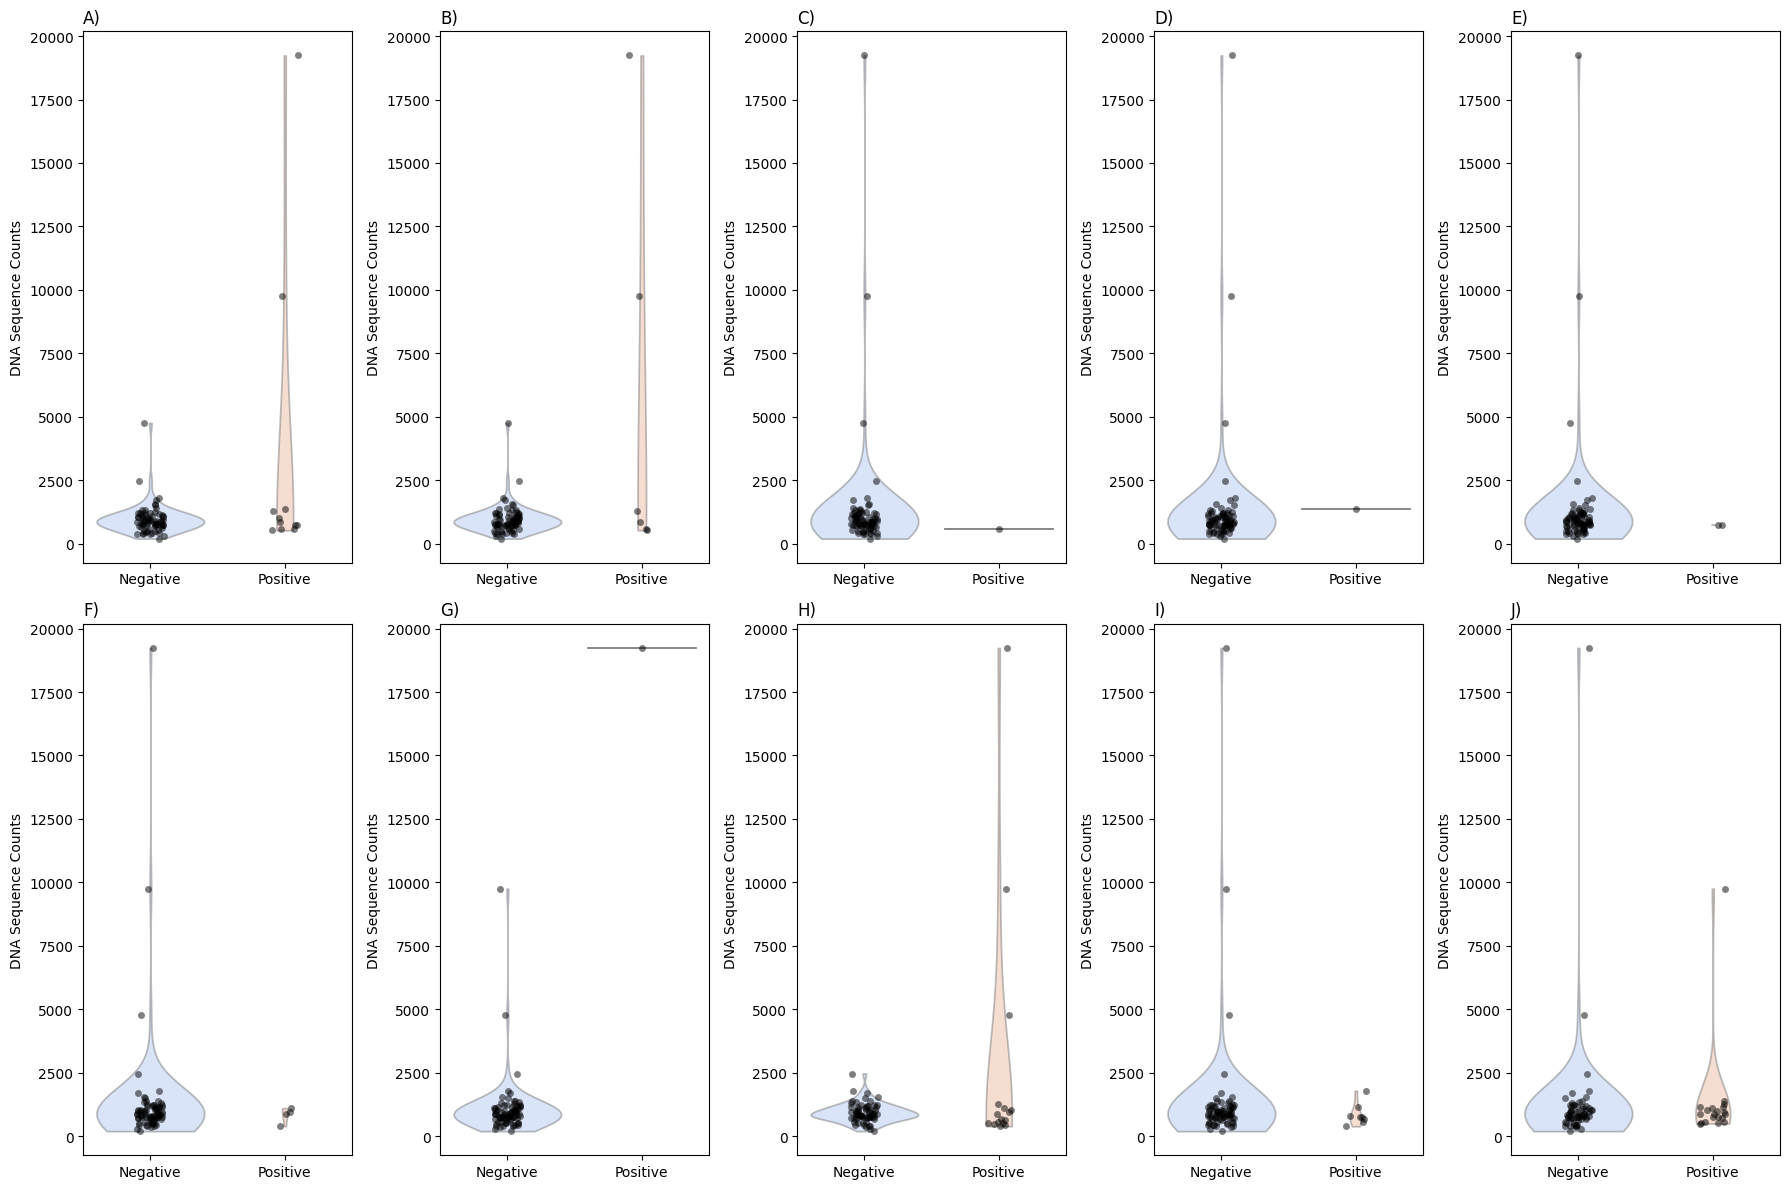

A) NTM culture status, B) Mycobacteroides abscessus culture status, C) Mycobacterium intracellulare culture status, D) NTM (Smear negative) culture status, E) MAC (Smear negative) culture status, F) Other Mycobacterium abscessus culture status, G) Other Mycobacterium intracellular culture status, H) P12M 4 Rapid NTM culture status, I) P12M 5 Slow NTM culture status, J) N12M MAC culture status, 


In [5]:
fig, ax = plt.subplots(figsize=(18, 12), nrows=2, ncols=5, sharex=False, sharey=False)

y='Mycobacteriaceae'
k = 0
letter = 65
legendstr = ""
for i in [0, 1]:
    for j in [0, 1, 2, 3, 4]:
        culture_taxa = myco.columns[k]
        ctitle = culture_taxa.replace('O_', 'Other ').replace('CS_', '').replace('_', ' ')
        g = sns.violinplot(x=culture_taxa, y=y, data=merged, hue=culture_taxa, palette='coolwarm', alpha=0.5, ax=ax[i][j], legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
        g = sns.stripplot(x=culture_taxa, y=y, data=merged, color='black', jitter=True, alpha=0.5, ax=ax[i][j], legend=False)
        g.set_xlabel("")
        g.set_ylabel("DNA Sequence Counts")
        g.set_xlim(-0.5, 1.5)
        g.set_xticks(ticks=[0, 1], labels=["Negative", "Positive"])
        legendstr += f"{chr(letter)}) {ctitle} culture status, "
        g.set_title(f"{chr(letter)})", loc='left')
        letter += 1
        k+=1
        

plt.tight_layout()
plt.savefig("final_images/figS4.png", dpi=300)
plt.savefig("final_images/figS4.svg", dpi=300)
plt.show()
print(legendstr)

### Read the autoencoder

In [6]:
encoder_models = 'cluster_gbrfs'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPF', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPF'] = cluster_assignments['COPF'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

## Which metadata columns are Mycobacteria?

In [7]:
for c in sorted(metadata.columns):
    if 'trichosporon mycotoxinivorans' in c.lower():
        # this is not mycobacteria :)
        continue
    if 'mac' in c.lower() or 'ntm' in c.lower() or 'myco' in c.lower():
        print(f"'{c}', ", end="")
print()

'CS_MAC_(Smear negative)', 'CS_Mycobacterium intracellulare', 'CS_Mycobacteroides abscessus', 'CS_Mycolicibacter terrae', 'CS_NTM_(Smear negative)', 'N12M_MAC', 'NTM', 'O_Mycobacterium abscessus', 'O_Mycobacterium intracellular', 'O_Mycobacterium mucogenicum', 'O_Mycobacterium scotochromogen', 'P12M_4_Rapid NTM', 'P12M_5_Slow NTM', 


### Who has what?

We have several different scores for Mycobacteria, and this allows us to chose a subset to see if there is an effect.

Note that 'NTM' means any of `CS_Mycobacteroides abscessus`, `CS_Mycobacterium intracellulare`, `CS_Mycolicibacter terrae`, `CS_NTM_(Smear negative)`, `CS_MAC_(Smear negative)` are positive, but also sample _763742\_20170925\_S_ notes that they have a `Culture Result (Matched with sequenced sample): Candida albicans; unspecified NTM (smear negative)`

In [8]:
print("Measurement | Number of positive samples")
for c in ['CS_MAC_(Smear negative)', 'CS_Mycobacterium intracellulare', 'CS_Mycobacteroides abscessus', 'CS_Mycolicibacter terrae', 'CS_NTM_(Smear negative)', 
                     'N12M_MAC', 'NTM', 
                     'O_Mycobacterium abscessus', 'O_Mycobacterium intracellular', 'O_Mycobacterium mucogenicum', 'O_Mycobacterium scotochromogen', 
                     'P12M_4_Rapid NTM', 'P12M_5_Slow NTM'
                ]:
    print(f"{c} | {metadata[c].dropna(axis=0).astype(int).sum()}")

Measurement | Number of positive samples
CS_MAC_(Smear negative) | 2
CS_Mycobacterium intracellulare | 1
CS_Mycobacteroides abscessus | 6
CS_Mycolicibacter terrae | 1
CS_NTM_(Smear negative) | 1
N12M_MAC | 21
NTM | 11
O_Mycobacterium abscessus | 5
O_Mycobacterium intracellular | 1
O_Mycobacterium mucogenicum | 2
O_Mycobacterium scotochromogen | 2
P12M_4_Rapid NTM | 19
P12M_5_Slow NTM | 9


In [9]:
metadata[metadata['NTM'] == 1][['pwCF_ID', 'NTM', 'CS_Mycobacteroides abscessus', 'CS_Mycobacterium intracellulare', 'CS_Mycolicibacter terrae', 'CS_NTM_(Smear negative)', 'CS_MAC_(Smear negative)']]

,pwCF_ID,NTM,CS_Mycobacteroides abscessus,CS_Mycobacterium intracellulare,CS_Mycolicibacter terrae,CS_NTM_(Smear negative),CS_MAC_(Smear negative)
NAME,,,,,,,
1162967_20180116_S,1162967,1.0,0,0,1,0,0
642660_20180601_S,642660,1.0,1,1,0,0,0
670829_20171001_S,670829,1.0,1,0,0,0,0
698564_20181205_S,698564,1.0,0,0,0,1,0
698917_20171207_S,698917,1.0,1,0,0,0,0
717449_20180606_S,717449,1.0,1,0,0,0,0
720054_20170925_S,720054,1.0,0,0,0,0,1
720054_20171120_S,720054,1.0,0,0,0,0,1
753522_20180606_S,753522,1.0,1,0,0,0,0


In [10]:
if 'Mycobacteria' in metadata.columns:
    metadata = metadata.drop('Mycobacteria', axis=1)
    
myco_all = metadata[['CS_MAC_(Smear negative)', 'CS_Mycobacterium intracellulare', 'CS_Mycobacteroides abscessus', 'CS_Mycolicibacter terrae', 'CS_NTM_(Smear negative)', 
                     'N12M_MAC', 'NTM', 
                     'O_Mycobacterium abscessus', 'O_Mycobacterium intracellular', 'O_Mycobacterium mucogenicum', 'O_Mycobacterium scotochromogen', 
                     'P12M_4_Rapid NTM', 'P12M_5_Slow NTM'
                ]].dropna(axis=0).copy()

myco_now = metadata[['CS_MAC_(Smear negative)', 'CS_Mycobacterium intracellulare', 'CS_Mycobacteroides abscessus', 
                     'CS_Mycolicibacter terrae', 'CS_NTM_(Smear negative)']].dropna(axis=0).copy()

myco_mac = metadata[['CS_MAC_(Smear negative)', 'CS_Mycobacteroides abscessus',  'O_Mycobacterium abscessus']].dropna(axis=0).copy()

myco_mac_any = metadata[['CS_MAC_(Smear negative)', 'CS_Mycobacteroides abscessus',  'O_Mycobacterium abscessus', 'P12M_5_Slow NTM', 'N12M_MAC']].dropna(axis=0).copy()

myco_ntm = metadata[['NTM']].dropna(axis=0).copy()

# change the line below to one of the above!
which_myco = myco_ntm


which_myco['Mycobacteria_sum'] = which_myco.astype(int).sum(axis=1)
which_myco['Mycobacteria'] = which_myco['Mycobacteria_sum'] > 0

# myco[myco['Mycobacteria']].to_csv('mycobacteria/mycobacteria.tsv', sep="\t")

metadata['Mycobacteria'] = which_myco['Mycobacteria'].astype(int).astype('category')

print(f"There are {which_myco[which_myco['Mycobacteria']].shape[0]} samples that have Mycobacteria", file=sys.stderr)

There are 11 samples that have Mycobacteria


#### Which samples have any signal of Mycobacterium

In [30]:
ma = myco_all.drop('NTM', axis=1)
ma['Mycobacteria_sum'] = ma.astype(int).sum(axis=1)
all_myco = metadata[['pwCF_ID', 'Sample date']].join(ma[ma['Mycobacteria_sum'] > 0], how='right')
# uncomment the next line to save as an excel file!
# all_myco.to_excel("mycobacteria.xlsx", sheet_name="Mycobacterial Samples", index=True)

## Run the Gradient Boosted Random Forest

The data for the classifier is {'no': 114, 'yes': 11} variables
We used 200 estimators for the random forest classifier


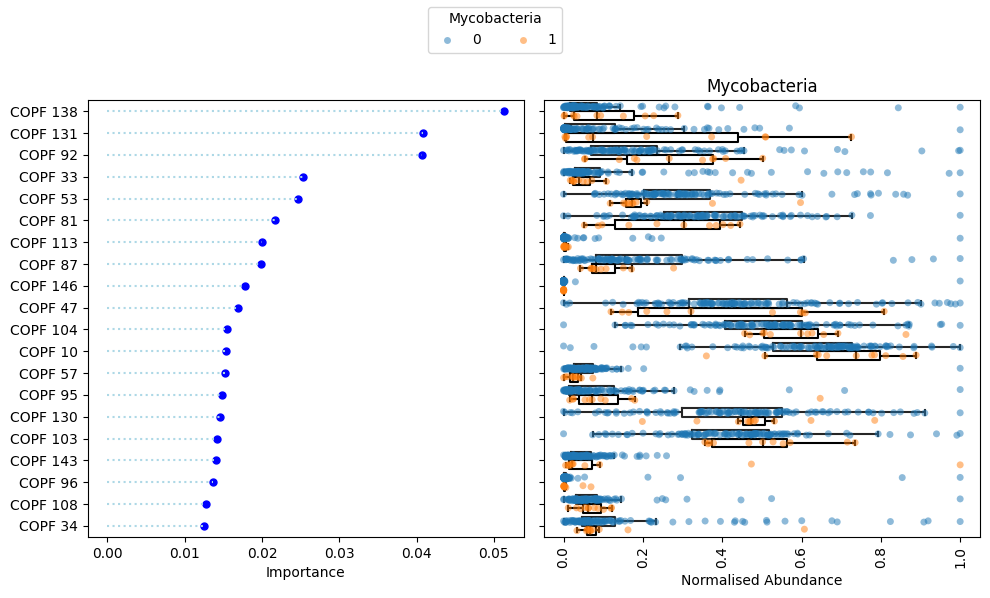

In [11]:
intcol = 'Mycobacteria'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, custom_labels)

## Use SHAP to find the features that are important for the presence of something

Right now the GBRF is agnostic to whether an important feature is associated with presence (1) or absence (0) — it just finds features that split the data well.

Here, we loook for things positively associated with 1.

In [12]:
positive_label=1
top_n=None
output_space: str = "probability"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Map presence label to model class index
classes = np.asarray(model.classes_)
if positive_label not in classes:
    raise ValueError(f"positive_label {positive_label!r} not in model.classes_: {classes}")
pos_idx = int(np.where(classes == positive_label)[0][0])

# Configure explainer safely
if output_space == "probability":
    explainer = shap.TreeExplainer(
        model,
        model_output="raw",
        feature_perturbation="interventional",  # required for probability output
    )
elif output_space == "raw":
    # Fast path (tree_path_dependent); values are in log-odds
    explainer = shap.TreeExplainer(model)
else:
    raise ValueError('output_space must be "probability" or "raw"')

shap_values = explainer.shap_values(X)

# Normalize shapes:
# - Multiclass: list of arrays, one per class -> pick pos_idx
# - Binary:
#   * "probability": newer SHAP typically returns a list [class0, class1]; pick pos_idx
#   * Sometimes returns a single array for P(last_class); if presence != last class, flip sign
#   * "raw": often a single array of log-odds; direction is toward the model's positive output
if isinstance(shap_values, list):
    shap_presence = shap_values[pos_idx]  # shape (n_samples, n_features)
else:
    shap_presence = shap_values  # shape (n_samples, n_features)
    if output_space == "probability":
        # Probability single-array case corresponds to last class
        if pos_idx != (len(classes) - 1):
            shap_presence = -shap_presence
    else:
        # Raw log-odds single-array: sign already indicates move toward the model's raw output
        # (which corresponds to the last class). Flip if presence is not the last class.
        if pos_idx != (len(classes) - 1):
            shap_presence = -shap_presence

mean_shap_presence = shap_presence.mean(axis=0)

ranked_df = pd.DataFrame({
    "feature": X.columns,
    "mean_shap_for_presence": mean_shap_presence
})
ranked_df["abs_mean_shap"] = ranked_df["mean_shap_for_presence"].abs()
ranked_df = ranked_df.sort_values(
    ["mean_shap_for_presence", "abs_mean_shap"],
    ascending=[False, False]
).reset_index(drop=True)




In [13]:
shap_values_df = pd.DataFrame(shap_values, index=X.index, columns=X.columns)
shap_values_df[['COPF 131', 'COPF 3']]

,COPF 131,COPF 3
1068841_20180306_S,0.015061,-0.009779
1447437_20171212_S,-0.033707,-0.008239
1128691_20171206_S,-0.039245,-0.008004
1128691_20171218_S,-0.039527,-0.007902
1128691_20180116_S,-0.038929,-0.005682
...,...,...
895293_20180502_S,-0.038916,-0.010732
896213_20180427_S,-0.038708,-0.007154
913873_20180417_S,-0.037029,-0.004687
980574_20180403_S,0.007651,-0.007891


In [14]:
shap_presence_df = pd.DataFrame(shap_presence, index=X.index, columns=X.columns)
shap_presence_df[['COPF 131', 'COPF 3']]

,COPF 131,COPF 3
1068841_20180306_S,0.015061,-0.009779
1447437_20171212_S,-0.033707,-0.008239
1128691_20171206_S,-0.039245,-0.008004
1128691_20171218_S,-0.039527,-0.007902
1128691_20180116_S,-0.038929,-0.005682
...,...,...
895293_20180502_S,-0.038916,-0.010732
896213_20180427_S,-0.038708,-0.007154
913873_20180417_S,-0.037029,-0.004687
980574_20180403_S,0.007651,-0.007891


This is the importance of positively predicting the presence of Mycobacteria

In [15]:
mean_shap_presence = shap_presence.mean(axis=0)
mean_shap_presence_df = pd.DataFrame(mean_shap_presence, index=X.columns, columns=['Mean Shap Presence'])
mean_shap_presence_df['Abs'] = mean_shap_presence_df['Mean Shap Presence'].abs()
mean_shap_presence_df.sort_values(by='Mean Shap Presence', ascending=False)

,Mean Shap Presence,Abs
COPF 108,0.003273,0.003273
COPF 9,0.002182,0.002182
COPF 90,0.002143,0.002143
COPF 42,0.002075,0.002075
COPF 103,0.002029,0.002029
...,...,...
COPF 127,-0.003441,0.003441
COPF 36,-0.004422,0.004422
COPF 138,-0.005597,0.005597
COPF 53,-0.005606,0.005606


This shows the importance from the variable importance plot above and/or the shap plot below

In [16]:
abs_mean = np.abs(shap_presence).mean(axis=0)

compare_df = pd.DataFrame({
    "feature": X.columns,
    "mean_signed": shap_presence.mean(axis=0),
    "mean_abs": abs_mean
}).sort_values("mean_abs", ascending=False)

compare_df.head(20)

,feature,mean_signed,mean_abs
137,COPF 138,-0.005597,0.075884
130,COPF 131,0.000511,0.054106
94,COPF 95,-0.003375,0.047933
91,COPF 92,0.001203,0.047674
112,COPF 113,-0.009253,0.040566
32,COPF 33,-0.001352,0.038024
52,COPF 53,-0.005606,0.034283
103,COPF 104,0.001080,0.026587
46,COPF 47,-0.002282,0.025772
35,COPF 36,-0.004422,0.023411


In [17]:
cluster_assignments[cluster_assignments['Feature'].str.lower().str.contains('myco')].sort_values(by='COPF')

,COPF,Feature
151,28,Biosynthesis of Arabinogalactan in Mycobacteria
186,31,Mycobacterial gene cluster associated with res...
187,31,Mycobacterial FadE proteins Acyl-CoA dehydroge...
188,31,Mycobacterial FadD proteins (fatty acid CoA- a...
294,37,Mycolic acid synthesis 2
310,41,Mycobacterial heme acquisition system
329,43,Mycobacterial HadABC proteins ((3R)-hydroxyacy...
333,43,Glutathione analogs: mycothiol
416,63,Mycobacterial lipoproteins (LPR group)
553,87,Galactosamine Substituent of Arabinogalactan i...


This shap plot shows the importance of positively predicting Mycobacteria

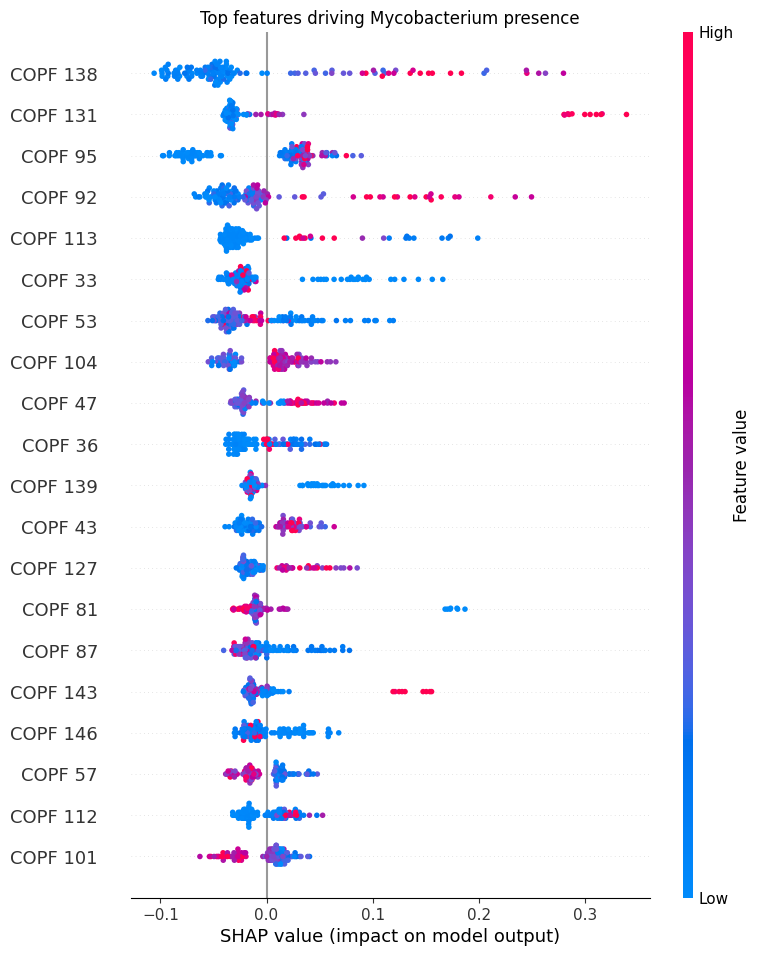

In [18]:
shap.summary_plot(shap_presence, X, show=False)
plt.title("Top features driving Mycobacterium presence")
plt.show()


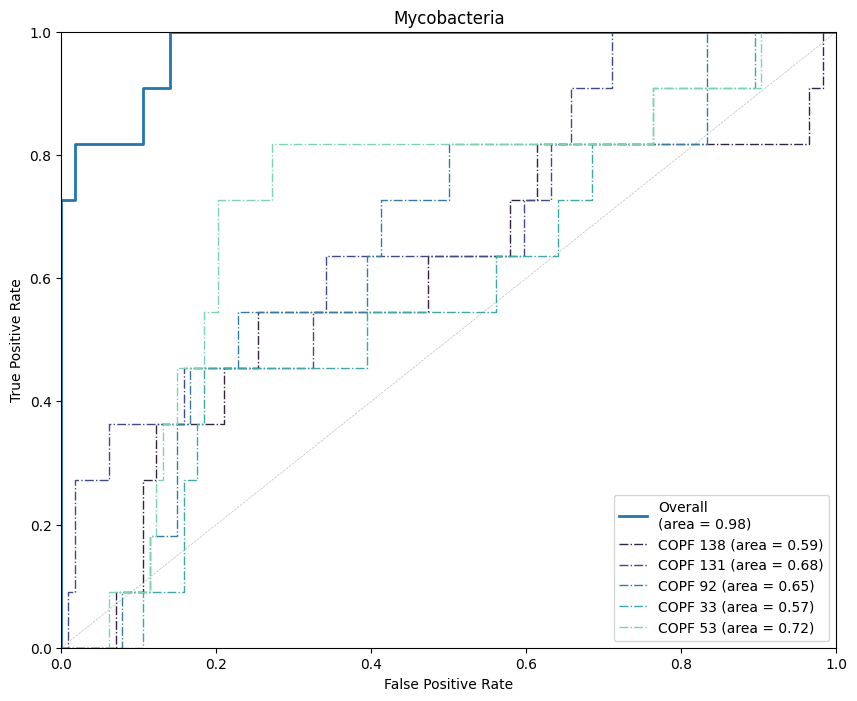

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = cf_analysis_lib.plot_roc_curves(model, X, y, feature_importances_sorted, met, intcol_title, ax=ax)
plt.show()

'Mycobacteria' has samples from 11 pwCF


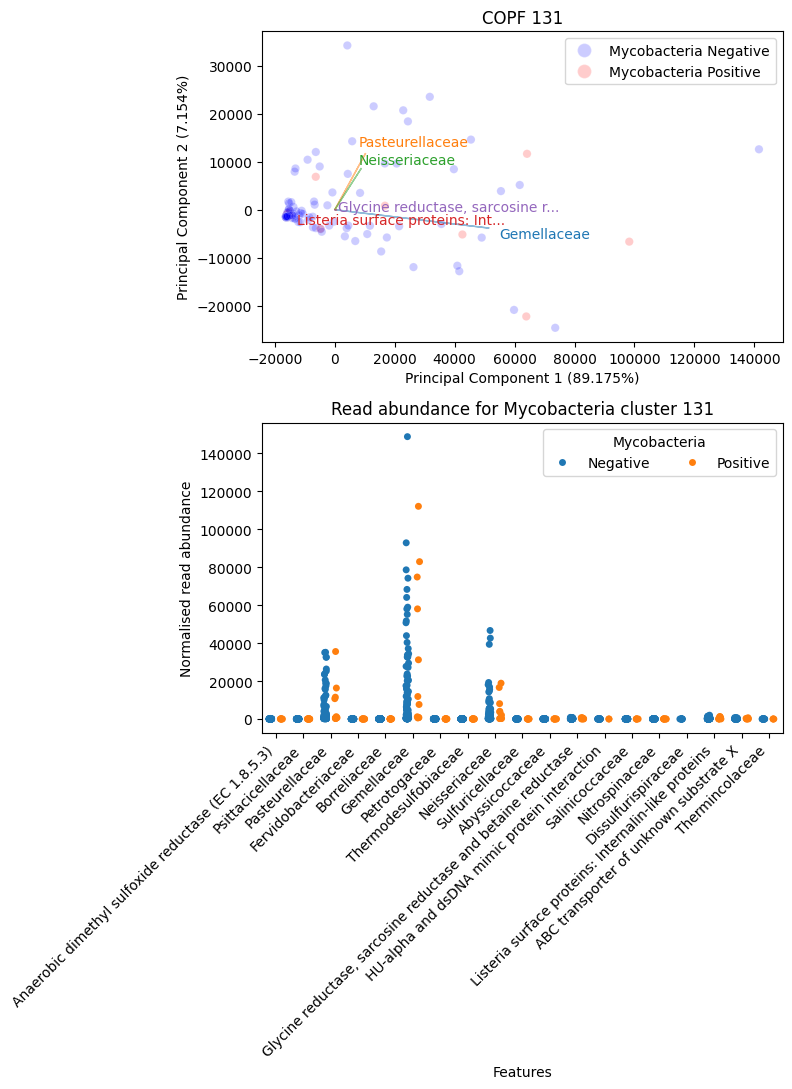

In [20]:
interesting_cluster = 131
print(f"'{intcol}' has samples from {metadata.groupby(intcol).size()[1]} pwCF")

if isinstance(interesting_cluster, int):
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
elif 'COPF' in interesting_cluster:
    interesting_cluster_filename = interesting_cluster.replace(" ", "_")
else:
    interesting_cluster_filename = f"COPF_{interesting_cluster}"
intcol_filename = intcol.replace(" ", "_")
intcol_filename = replace_nonword.sub('', intcol_filename)


# make a new dir so we don't overwrite!
#os.makedirs(os.path.join(outdir, "img", "clusters_manual"), exist_ok=True)

pca = PCA(n_components=2)
int_cluster_num = interesting_cluster

df_clust = df[cluster_assignments.loc[cluster_assignments["COPF"] == int_cluster_num, "Feature"]]
merged_df_clust = df_clust.join(metadata[intcol], how='inner')
df_clust = merged_df_clust.drop(intcol, axis=1)

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df_clust.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

# don't forget to change the legend
intcol_neg = 0

colours = np.where(merged_df_clust[intcol] == intcol_neg, 'blue', 'red')

# Plot the PCA results
fig, axes = plt.subplots(figsize=(8, 11), nrows=2, ncols=1)
ax = axes[0]
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.2, c=colours, ax=ax)
ax.set_title(f"COPF {interesting_cluster}")
ax.set_xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
ax.set_ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)


for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    ax.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    loading_text = top_loadings_df.index[i]
    if len(loading_text) > 30:
        loading_text = loading_text[:30] + "..."
    texts.append(ax.text(xpos, ypos, loading_text, color=c))

adjust_text(texts, ax=ax)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Negative', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label=f'{intcol} Positive', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
ax.legend(handles=[blue_patch, red_patch])

## Read abundance
ax = axes[1]

df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]

cl = {'IP': 'red', 'OP': 'blue'}
g = sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True, ax=ax)
custom_labels = {0: 'Negative', 1: 'Positive'}
handles, labels = g.get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[float(label)] for label in labels]
g.get_legend().remove()
g.legend(handles, updated_labels, loc='upper right', ncol=2, title=intcol_title)

ax.tick_params(axis='x', rotation=45)
for label in ax.get_xticklabels():
    label.set_horizontalalignment('right')
ax.set_title(f"Read abundance for {intcol} cluster {interesting_cluster}")


plt.tight_layout()
# plt.savefig(os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png"))
# print(f'Wrote the new image to {os.path.join(outdir, "img", "clusters_manual", f"{intcol_filename}_{interesting_cluster_filename}.png")}', file=sys.stderr)
# Show the plot
plt.show()